<center><h1>1-e: Transformers</h1></center>
<center><h2><a href="https://rdfia.github.io/">Course link</a></h2></center>


# Warning :
# Do "File -> Save a copy in Drive" before you start modifying the notebook, otherwise your modifications will not be saved.

In this notebook, we will implement the first Visual Transformer, [ViT](https://arxiv.org/abs/2010.11929). We'll implement a naive version of it, much smaller than the ones described in the paper, and we also won't use complex data augmentation and regularizations. But note that this is important to make transformers work in practice on large-scale dataset.

To get a gist of what is required to make a transformer work in practice, have a look at the [DeiT and CaiT codebase](https://github.com/facebookresearch/deit).

This notebook is a simplified version of the excellent [Timm library](https://github.com/rwightman/pytorch-image-models).

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
import pickle
import math

import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
from torchvision.datasets import ImageFolder
from torchvision import transforms
import torchvision.utils as vutils
import torchvision
from PIL import Image
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, random_split

Let's load the MNIST dataset:

In [ ]:


# Define the transformation
transform = transforms.Compose([
    transforms.ToTensor()
])

# Load the full MNIST dataset
full_dataset = torchvision.datasets.MNIST('.', train=True, download=True, transform=transform)

# Define the sizes of the training and validation sets
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size

# Split the dataset into training and validation sets
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# Create data loaders for training, validation, and testing
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataset = torchvision.datasets.MNIST('.', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset))



100%|██████████| 9912422/9912422 [00:00<00:00, 151626049.86it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 27505834.20it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 44591036.50it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 5867116.96it/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



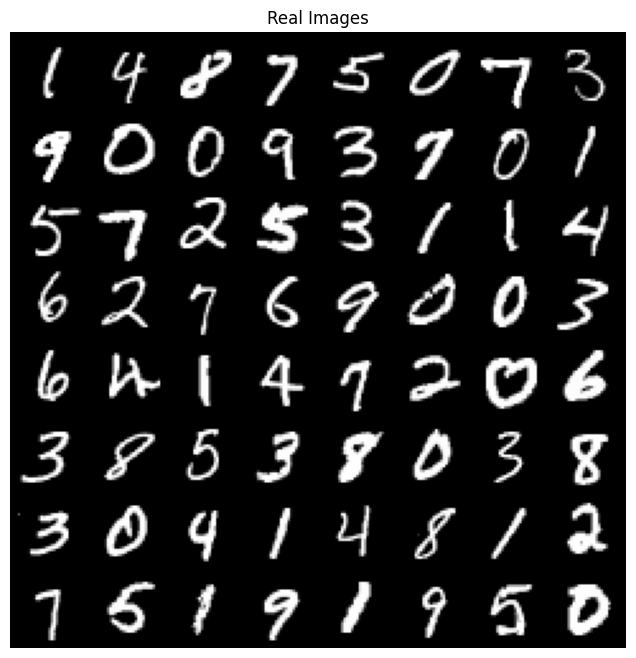

In [ ]:
real_batch = next(iter(train_loader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Real Images")
plt.imshow(vutils.make_grid(real_batch[0][:64], normalize=True).permute(1,2,0))
plt.show()

... and visualize!

# Here is the general architecture of the ViT model
## The architecture includes:
- A step for splitting the image into disjoint patches with a linear projection of the patches
- Positional encoding to capture the absolute spatial information of each patch in the image
- The addition of a "[CLS]" token, initialized randomly and learned during training
- A transformer encoder that learns the representation of each token
- A classification head that performs class prediction from the re-embedded [CLS] token at the output of the encoder

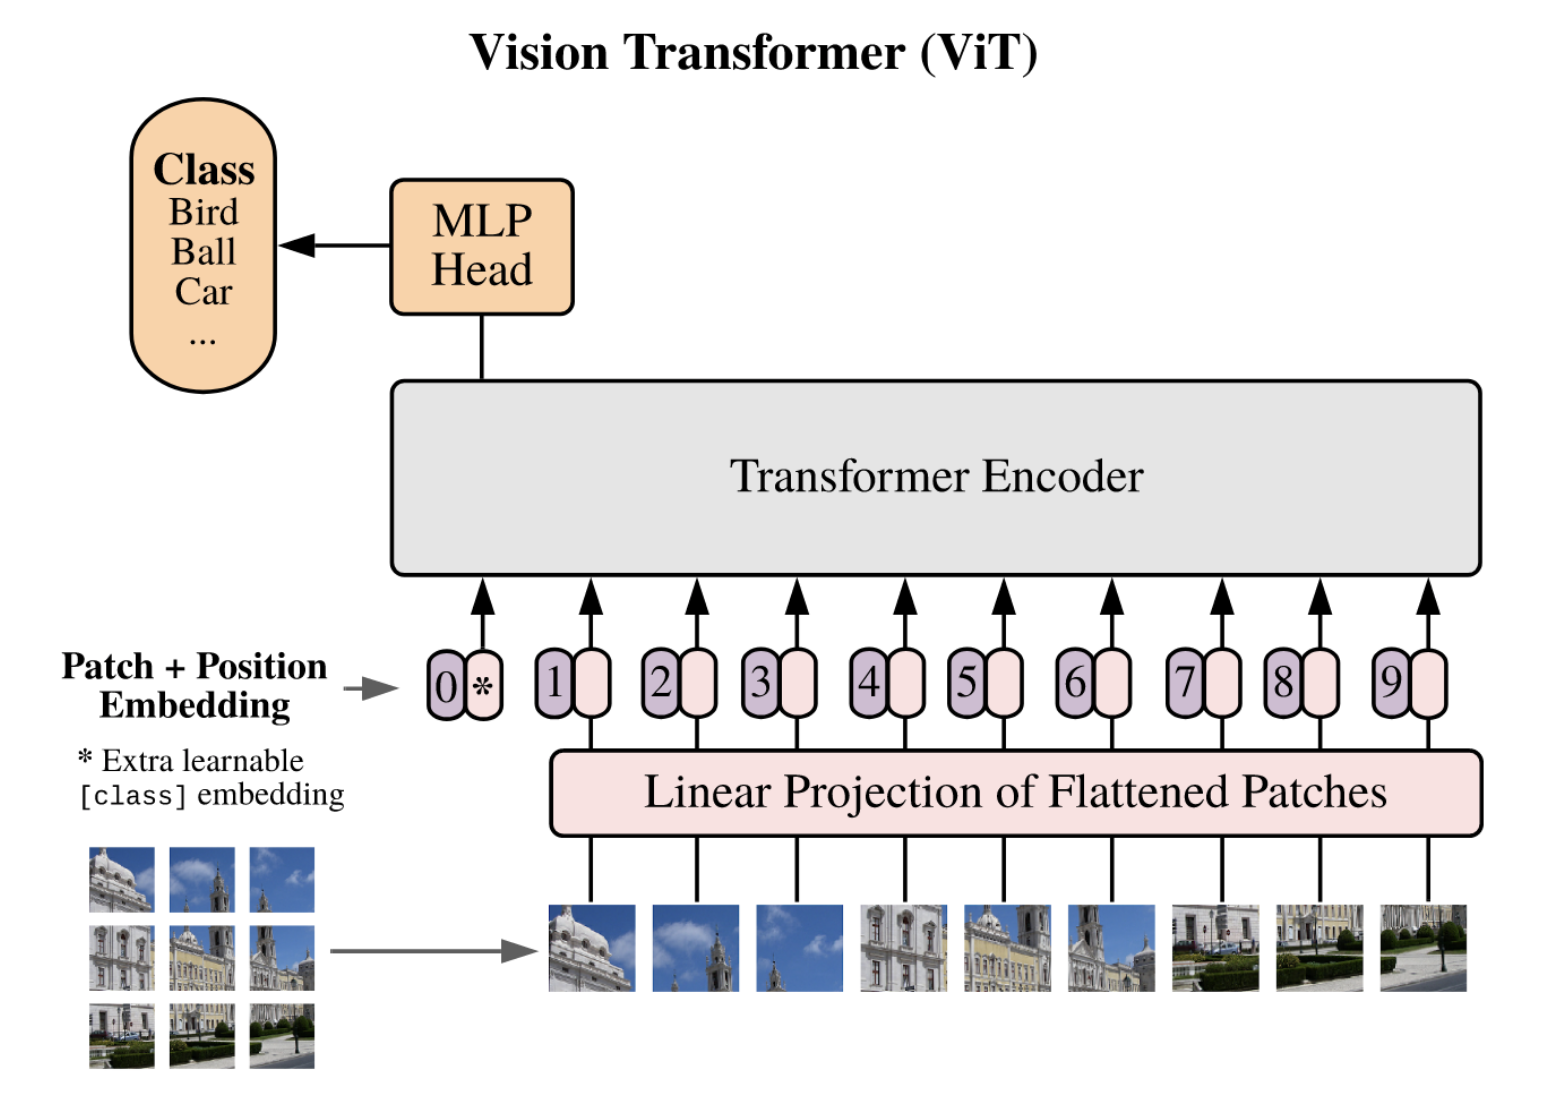

# Linear Projection of flattened patches

**Q1**:
First, we need to code the patch embedding. In NLP, it could be using a word2vec embeddings, but we need something different in Computer Vision.

You are going to use a specific 2d convolution to play the role of the so-called "Linear Projection" on the image above and process each patch independently without overlap. Think a bit how you could do that.

Then, you need to manipulate the dimensions of the resulting tensor to get a final tensor of shape `(batch_size, nb_tokens, embedding_dim)`. *Hint: You will need a `view/reshape` and `transpose/permute` operators*.

As usual, remember to check the output shape of your layer by trying with a random tensor!

In [ ]:
class PatchEmbed(nn.Module):
  def __init__(self, in_chan=1, patch_size=7, embed_dim=128):
    super().__init__()
    ## TODO
    self.projection = nn.Conv2d(in_chan, embed_dim, kernel_size=patch_size, stride=patch_size)

  def forward(self, x):
    x = self.projection(x)

    B, C, H, W = x.shape
    ## TODO
    x = x.flatten(2)
    x = x.transpose(1,2)

    # x.shape() -> B, N, C
    return x


In [ ]:
real_batch = next(iter(train_loader))
print(real_batch[0].shape)
patchE = PatchEmbed()
patchE(real_batch[0]).shape

torch.Size([128, 1, 28, 28])


torch.Size([128, 16, 128])

# Transformer encoder

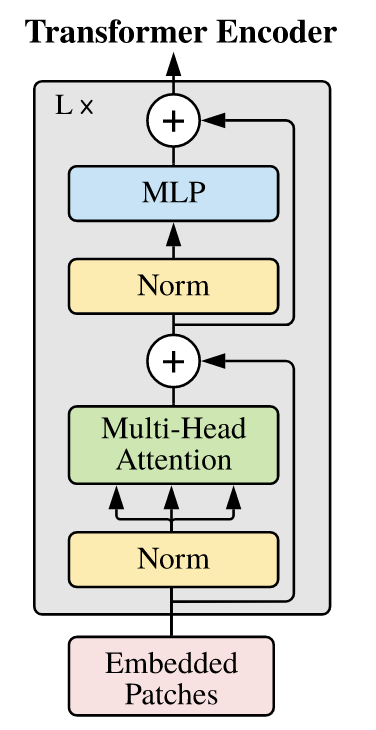

## Q2: MLP

Now we need to build a transformer block. Let's first build the easiest part, the MLP! By now, you should be confident how to code one.

Code a MLP with one hidden layer. Note that the input and output dimensions will be the same. Instead of ReLU, use the activation GELU, which is a slight alternative often used for transformers.

In [ ]:
class MLP(nn.Module):
  def __init__(self, in_features, hid_features):
    super().__init__()

    # TODO
    self.fc1 = nn.Linear(in_features, hid_features)
    self.fc2 = nn.Linear(hid_features, in_features)


  def forward(self, x):
    # TODO
    x = self.fc1(x)
    x = F.gelu(x)
    x = self.fc2(x)

    return x


MLP(128, 512)(torch.randn(32, 16, 128)).shape

torch.Size([32, 16, 128])

**texte en gras**## Q3: Self-attention

Now we are going to build the famous **Self-Attention**.
- What is the main feature of self-attention, especially compared to its convolutional counterpart. What is its main challenge in terms of computation/memory?
- At first, we are going to only consider the simple case of one head. Write the equations and complete the following code. And don't forget a final linear projection at the end!




In [ ]:
import torch
import torch.nn as nn

class SelfAttention(nn.Module):
    def __init__(self, embed_dim, num_heads=1):
        super().__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads

        # Linear projections for Q, K, and V
        self.Wq = nn.Linear(embed_dim, embed_dim)
        self.Wk = nn.Linear(embed_dim, embed_dim)
        self.Wv = nn.Linear(embed_dim, embed_dim)

        # Final linear projection for the output
        self.Wo = nn.Linear(embed_dim, embed_dim)

    def forward(self, x):
        B, N, C = x.shape

        # Linearly project the input into Q, K, and V
        q = self.Wq(x)
        k = self.Wk(x)
        v = self.Wv(x)

        # Reshape Q, K, and V to have multiple heads
        q = q.view(B, N, self.num_heads, -1)
        k = k.view(B, N, self.num_heads, -1)
        v = v.view(B, N, self.num_heads, -1)

        # Transpose to prepare for attention calculation
        q = q.permute(0, 2, 1, 3)
        k = k.permute(0, 2, 1, 3)
        v = v.permute(0, 2, 1, 3)

        # Calculate the attention scores
        attention = torch.matmul(q, k.transpose(-2, -1)) / (self.embed_dim ** 0.5)

        # Apply softmax to get attention weights
        attention = torch.nn.functional.softmax(attention, dim=-1)

        # Use the attention weights to compute the weighted sum (attention mechanism)
        x = torch.matmul(attention, v)

        # Reshape and concatenate the multi-head attention outputs
        x = x.permute(0, 2, 1, 3).contiguous().view(B, N, -1)

        # Apply the final linear projection
        x = self.Wo(x)

        return x

SelfAttention(128)(torch.randn(32, 16, 128)).shape

torch.Size([32, 16, 128])

# Q4 : Multi-head self-attention

Now we need to build a Multi-Heads Self-Attention.
- Write the equations and complete the following code to build a Multi-Heads Self-Attention.
- The total embedding size will be shared equally among all heads.

In [ ]:
import torch
import torch.nn as nn

class MultiHeadsSelfAttention(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super().__init__()

        # Calculate the dimension of each head
        head_dim = embed_dim // num_heads
        self.scale = head_dim ** -0.5
        self.num_heads = num_heads

        # Linear projections for Q, K, and V for each head
        self.Wq = nn.Linear(embed_dim, embed_dim)
        self.Wk = nn.Linear(embed_dim, embed_dim)
        self.Wv = nn.Linear(embed_dim, embed_dim)

        # Final linear projection for the output
        self.projection = nn.Linear(embed_dim, embed_dim)

    def forward(self, x):
        B, N, C = x.shape

        # Linearly project the input into Q, K, and V
        q = self.Wq(x)
        k = self.Wk(x)
        v = self.Wv(x)

        # Split Q, K, and V into multiple heads
        q = q.view(B, N, self.num_heads, -1).permute(0, 2, 1, 3)
        k = k.view(B, N, self.num_heads, -1).permute(0, 2, 1, 3)
        v = v.view(B, N, self.num_heads, -1).permute(0, 2, 1, 3)

        # Calculate the attention scores
        attention = torch.matmul(q, k.permute(0, 1, 3, 2)) * self.scale

        # Apply softmax to get attention weights
        attention = torch.nn.functional.softmax(attention, dim=-1)

        # Use the attention weights to compute the weighted sum (attention mechanism)
        x = torch.matmul(attention, v)

        # Reshape and concatenate the multi-head attention outputs
        x = x.permute(0, 2, 1, 3).contiguous().view(B, N, -1)

        # Apply the final linear projection
        x = self.projection(x)

        return x
MultiHeadsSelfAttention(6, 2)(torch.randn(32, 16, 6)).shape

torch.Size([32, 16, 6])

# Q5: Transfomer block

Now, we need to build a Transformer **Block** as described in the image below.
- Write the equations and complete the following code.
- For the Layer Normalization, use PyTorch LayerNorm: https://pytorch.org/docs/stable/generated/torch.nn.LayerNorm.html

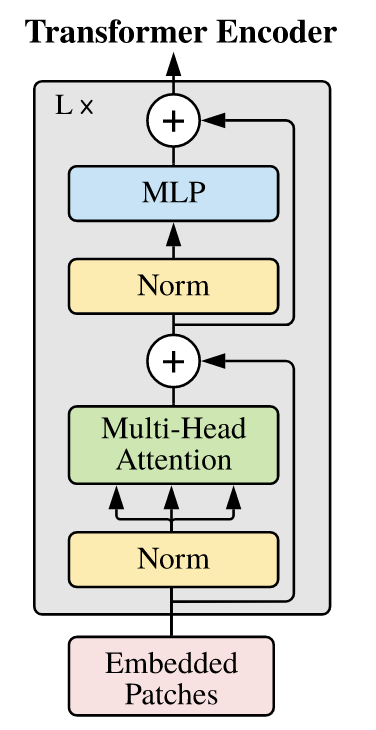

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Block(nn.Module):
    def __init__(self, embed_dim, num_heads=4, mlp_ratio=4):
        super().__init__()

        self.norm1 = nn.LayerNorm(embed_dim)
        self.attention = MultiHeadsSelfAttention(embed_dim, num_heads)

        self.norm2 = nn.LayerNorm(embed_dim)
        mlp_hidden_dim = mlp_ratio * embed_dim
        self.mlp = MLP(embed_dim, mlp_hidden_dim)


    def forward(self, x):
        # Multi-head self-attention and residual connection
        x_norm1=self.norm1(x)
        attn_output = self.attention(x)


        x = x_norm1 + attn_output
        x_norm2 = self.norm2(x)

        # Feedforward network and residual connection
        mlp_output = self.mlp(x)
        x = x_norm2 + mlp_output

        return x

# Example usage:
block = Block(128)
output = block(torch.randn(32, 16, 128))
print(output.shape)


torch.Size([32, 16, 128])


# Q6: Full ViT model

Now you need to build a ViT model based on what you coded in the previous questions. There are additional components that should be coded such as the Class token, Positional embedding and the classification head.

- Explain what is a Class token and why we use it? \\
- Explain whay is the the positional embedding (PE) and why it is important? \\

For PE, you can use a sinusoidal encoding (see below), or fully learned.


### Sinusoidal PE


In [ ]:
def get_positional_embeddings(sequence_length, d):
    result = torch.ones(1,sequence_length, d)
    for i in range(sequence_length):
        for j in range(d):
            result[0][i][j] = np.sin(i / (10000 ** (j / d))) if j % 2 == 0 else np.cos(i / (10000 ** ((j - 1) / d)))
    return result

In [ ]:
class ViT(nn.Module):
    def __init__(self, embed_dim, nb_blocks, patch_size, num_classes=10):
        super().__init__()

        num_patches = (28 // patch_size) ** 2

        self.class_token = nn.Parameter(torch.randn(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(get_positional_embeddings(num_patches+1, embed_dim))
        self.patch_embed = PatchEmbed(patch_size=patch_size, embed_dim=embed_dim)

        blocks = []
        for _ in range(nb_blocks):
            blocks.append(Block(embed_dim))
        self.blocks = nn.Sequential(*blocks)

        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        x = self.patch_embed(x)
        B, N, C = x.shape

        # Add class token
        class_token = self.class_token.expand(B, 1, -1)
        x = torch.cat((class_token, x), dim=1)
        # Add positional embeddings
        #print(x.shape, self.pos_embed.shape)
        x = x + self.pos_embed

        # Forward through the transformer blocks
        x = self.blocks(x)

        # Global average pooling
        x = x.mean(1)

        # Normalize the output
        x = self.norm(x)

        # Classification output
        output = self.head(x)

        return output

# Example usage:
vit_model = ViT(128, 3, patch_size=7)
output = vit_model(torch.randn(32, 1, 28, 28))
print(output.shape)


torch.Size([32, 10])


# Q7: Experiment on MNIST!

A quick function to evaluate our model:

In [4]:
@torch.no_grad()
def eval_model(model, loader):
  model.eval()
  acc = 0.
  c = 0

  for x, y in loader:
    x, y = x.cuda(), y.cuda()
    yhat = model(x)

    acc += torch.sum(yhat.argmax(dim=1) == y).cpu().item()
    c += len(x)

  model.train()
  return round(100 * acc / c, 2)

And run! Feel free to try other hyperparameters.

In [ ]:
epochs = 10

embed_dim = 32
patch_size = 7
nb_blocks = 2


ACC_train=[]
ACC_val=[]
LOSS_train=[]
LOSS_val=[]


model = ViT(embed_dim, nb_blocks, patch_size).cuda()

opt = torch.optim.Adam(model.parameters())

for epoch in range(epochs):
  train_loss = 0.
  for x, y in train_loader:
    x, y = x.cuda(), y.cuda()

    opt.zero_grad()
    yhat = model(x)
    loss = F.cross_entropy(yhat, y)
    loss.backward()

    opt.step()

    train_loss += loss.item()
  acc_train=eval_model(model, train_loader)
  acc_val=eval_model(model, val_loader)

  x_val,y_val=next(iter(val_loader))
  x_val, y_val = x_val.cuda(), y_val.cuda()
  yhat_val = model(x_val)
  loss_val = F.cross_entropy(yhat_val, y_val)
  ACC_train.append(acc_train)
  ACC_val.append(acc_val)
  LOSS_train.append(train_loss/ len(train_loader))
  LOSS_val.append(loss_val.item())

  print(f"--- Epoch {epoch} ---")
  print(f"Train loss: {train_loss / len(train_loader)}")
acc = eval_model(model, test_loader)
print(f"Test accuracy: {acc}")


--- Epoch 0 ---
Train loss: 1.0476704150835674
--- Epoch 1 ---
Train loss: 0.2977155436674754
--- Epoch 2 ---
Train loss: 0.20517573954661686
--- Epoch 3 ---
Train loss: 0.16669977481166523
--- Epoch 4 ---
Train loss: 0.13950024222334226
--- Epoch 5 ---
Train loss: 0.12274570375184218
--- Epoch 6 ---
Train loss: 0.11293052657941977
--- Epoch 7 ---
Train loss: 0.10089343557755152
--- Epoch 8 ---
Train loss: 0.08829554004967213
--- Epoch 9 ---
Train loss: 0.08103211498508851
Test accuracy: 96.99


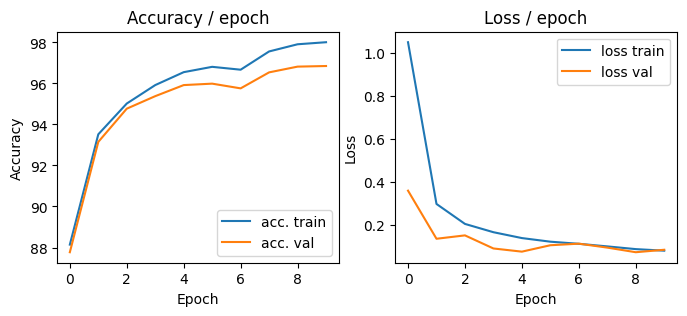

In [ ]:
plt.figure(figsize=(8,3))
plt.subplot(1,2,1)
plt.plot(np.array(ACC_train), label="acc. train")
plt.plot(np.array(ACC_val), label="acc. val")
plt.title("Accuracy / epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.subplot(1,2,2)
plt.plot(np.array(LOSS_train), label="loss train")
plt.plot(np.array(LOSS_val), label="loss val")
plt.title("Loss / epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.savefig('base performance')
plt.show()

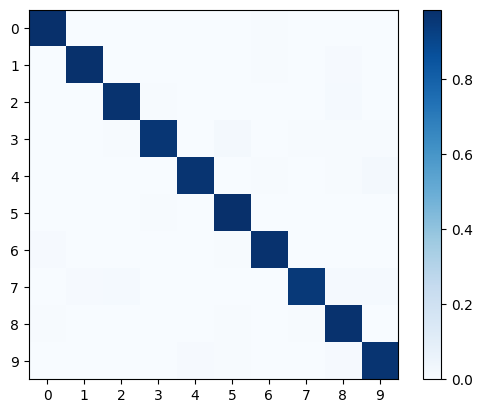

In [ ]:
from sklearn.metrics import confusion_matrix
X_test,Y_test=next(iter(test_loader))
X_test=X_test.cuda()
Y_test_hat=model(X_test)
Y_test_hat_copies=Y_test_hat.cpu()
cm=confusion_matrix(Y_test, Y_test_hat_copies.argmax(dim=1))
cm=cm/cm.sum(axis=1)[:, np.newaxis]
plt.imshow(cm, cmap=plt.cm.Blues)
plt.colorbar()
plt.xticks(range(10))
plt.yticks(range(10))
plt.savefig('confusion_matrix original')

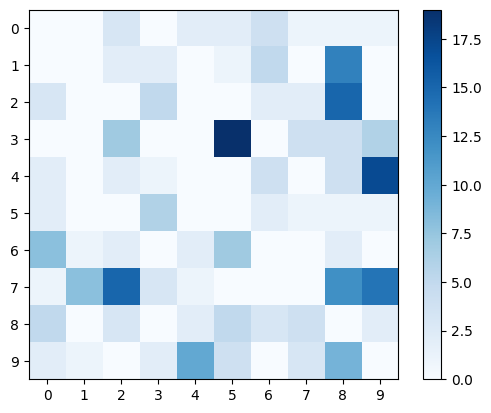

In [ ]:
cm=confusion_matrix(Y_test, Y_test_hat_copies.argmax(dim=1))
np.fill_diagonal(cm, 0)
plt.imshow(cm, cmap=plt.cm.Blues)
plt.colorbar()
plt.xticks(range(10))
plt.yticks(range(10))
plt.savefig('confusion_matrix original miclassed')

# Experimental analysis
- Test different hyperparameters and explain how they affect the performance. In particular embed_dim, patch_size, and nb_blocks.
- Comment and discuss the final performance that you get. How to improve it?
-  What is the complexity of the transformer in terms of number of tokens? How you can improve it?

In [ ]:
ACC_train=[]
ACC_val=[]
LOSS_train=[]
LOSS_val=[]

epochs = 10

embed_dim = 32
patch_size = 14
nb_blocks = 5

for embed_dim in [16,32,64,128,256]:


  ACC_train_temp=[]
  ACC_val_temp=[]
  LOSS_train_temp=[]
  LOSS_val_temp=[]


  model = ViT(embed_dim, nb_blocks, patch_size).cuda()

  opt = torch.optim.Adam(model.parameters())

  for epoch in range(epochs):
    train_loss = 0.
    for x, y in train_loader:
      x, y = x.cuda(), y.cuda()

      opt.zero_grad()
      yhat = model(x)
      loss = F.cross_entropy(yhat, y)
      loss.backward()

      opt.step()

      train_loss += loss.item()
    acc_train=eval_model(model, train_loader)
    acc_val=eval_model(model, val_loader)
    x_val,y_val=next(iter(val_loader))
    loss_val = F.cross_entropy(yhat, y)
    ACC_train_temp.append(acc_train)
    ACC_val_temp.append(acc_val)
    LOSS_train_temp.append(train_loss/ len(train_loader))
    LOSS_val_temp.append(loss_val.item())

    print(f"--- Epoch {epoch} ---")
    print(f"Train loss: {train_loss / len(train_loader)}")
  acc = eval_model(model, test_loader)
  print(f"Test accuracy: {acc}")
  ACC_train.append(ACC_train_temp)
  ACC_val.append(ACC_val_temp)
  LOSS_train.append(LOSS_train_temp)
  LOSS_val.append(LOSS_val_temp)


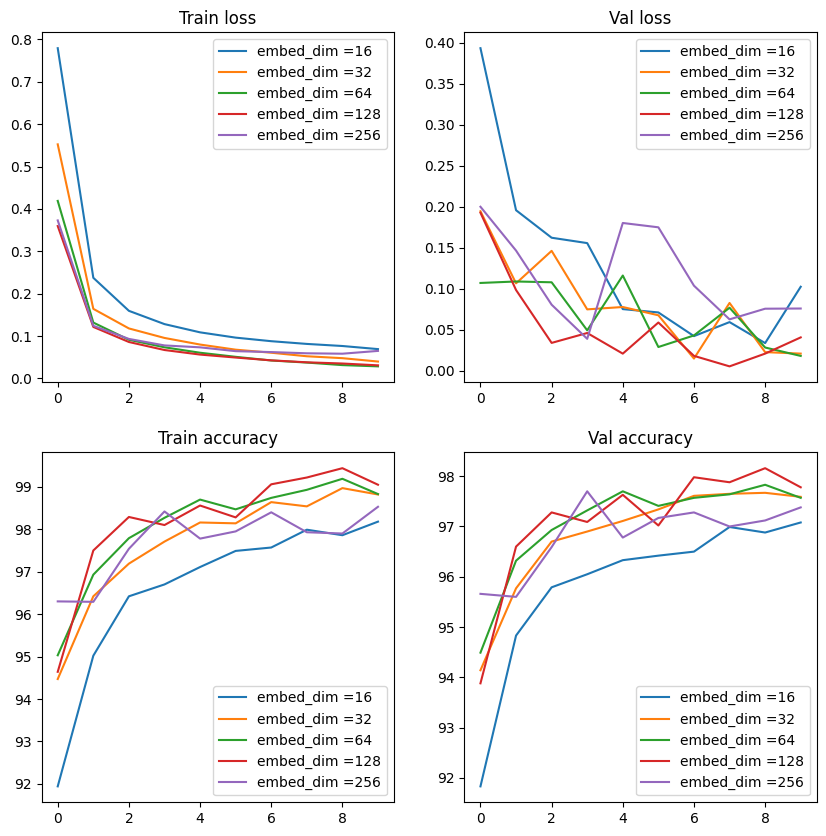

In [ ]:
fig1, axes1 = plt.subplots(2, 2, figsize=(10, 10))
axes1[0,0].set_title('Train loss')
axes1[0,1].set_title('Val loss')
axes1[1,0].set_title('Train accuracy')
axes1[1,1].set_title('Val accuracy')
for i,embed_dim in enumerate([16,32,64,128,256]):
  axes1[0,0].plot(LOSS_train[i],label="embed_dim ={}".format(embed_dim))
  axes1[0,1].plot(LOSS_val[i],label="embed_dim ={}".format(embed_dim))
  axes1[1,0].plot(ACC_train[i],label="embed_dim ={}".format(embed_dim))
  axes1[1,1].plot(ACC_val[i],label="embed_dim ={}".format(embed_dim))

axes1[0,0].legend()
axes1[1,0].legend()
axes1[0,1].legend()
axes1[1,1].legend()
fig1.savefig('embed_dim choices')

In [ ]:
epochs = 10

ACC_train_p=[]
ACC_val_p=[]
LOSS_train_p=[]
LOSS_val_p=[]

embed_dim = 32
patch_size = 7
nb_blocks = 2

for patch_size in [2,4,7,14]:

  ACC_train_temp=[]
  ACC_val_temp=[]
  LOSS_train_temp=[]
  LOSS_val_temp=[]


  model = ViT(embed_dim, nb_blocks, patch_size).cuda()

  opt = torch.optim.Adam(model.parameters())

  for epoch in range(epochs):
    train_loss = 0.
    val_loss=0.
    for x, y in train_loader:
      x, y = x.cuda(), y.cuda()

      opt.zero_grad()
      yhat = model(x)
      loss = F.cross_entropy(yhat, y)
      loss.backward()

      opt.step()

      train_loss += loss.item()

    for x, y in val_loader:
      x, y = x.cuda(), y.cuda()

      yhat = model(x)
      loss = F.cross_entropy(yhat, y)

      val_loss += loss.item()

    acc_train=eval_model(model, train_loader)
    acc_val=eval_model(model, val_loader)

    ACC_train_temp.append(acc_train)
    ACC_val_temp.append(acc_val)
    LOSS_train_temp.append(train_loss / len(train_loader))
    LOSS_val_temp.append(val_loss / len(val_loader))

    print(f"--- Epoch {epoch} ---")
    print(f"Train loss: {train_loss / len(train_loader)}")
    print(f"Test loss: {val_loss / len(val_loader)}")
  acc = eval_model(model, test_loader)
  print(f"Test accuracy: {acc}")
  ACC_train_p.append(ACC_train_temp)
  ACC_val_p.append(ACC_val_temp)
  LOSS_train_p.append(LOSS_train_temp)
  LOSS_val_p.append(LOSS_val_temp)


--- Epoch 0 ---
Train loss: 1.3336589063008626
Test loss: 0.5798177195990339
--- Epoch 1 ---
Train loss: 0.42208459790547687
Test loss: 0.3424819080119437
--- Epoch 2 ---
Train loss: 0.30634829858938856
Test loss: 0.29062978416047197
--- Epoch 3 ---
Train loss: 0.2600154395500819
Test loss: 0.23750096036398666
--- Epoch 4 ---
Train loss: 0.2206017402013143
Test loss: 0.22186947471283852
--- Epoch 5 ---
Train loss: 0.20015645788113276
Test loss: 0.232171237230935
--- Epoch 6 ---
Train loss: 0.18157622200250625
Test loss: 0.17493033369487904
--- Epoch 7 ---
Train loss: 0.16119832193851472
Test loss: 0.17842104357290775
--- Epoch 8 ---
Train loss: 0.14746559774875642
Test loss: 0.15188510200761735
--- Epoch 9 ---
Train loss: 0.13876547504464784
Test loss: 0.14671239213265003
Test accuracy: 95.88
--- Epoch 0 ---
Train loss: 1.22059925087293
Test loss: 0.49643428084698127
--- Epoch 1 ---
Train loss: 0.3736384065151215
Test loss: 0.31146563193265425
--- Epoch 2 ---
Train loss: 0.271423115690

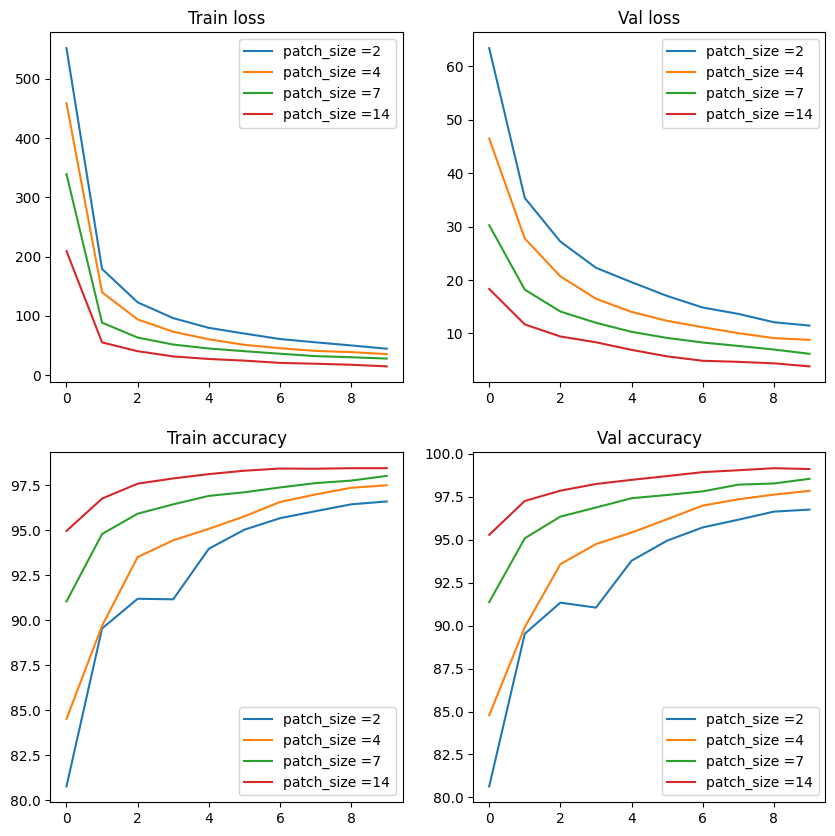

In [ ]:
fig1, axes1 = plt.subplots(2, 2, figsize=(10, 10))
axes1[0,0].set_title('Train loss')
axes1[0,1].set_title('Val loss')
axes1[1,0].set_title('Train accuracy')
axes1[1,1].set_title('Val accuracy')
for i,patch_size in enumerate([2,4,7,14]):
  axes1[0,0].plot(LOSS_train_p[i],label="patch_size ={}".format(patch_size))
  axes1[0,1].plot(LOSS_val_p[i],label="patch_size ={}".format(patch_size))
  axes1[1,0].plot(ACC_train_p[i],label="patch_size ={}".format(patch_size))
  axes1[1,1].plot(ACC_val_p[i],label="patch_size ={}".format(patch_size))

axes1[0,0].legend()
axes1[1,0].legend()
axes1[0,1].legend()
axes1[1,1].legend()
fig1.savefig('patch_size choices')

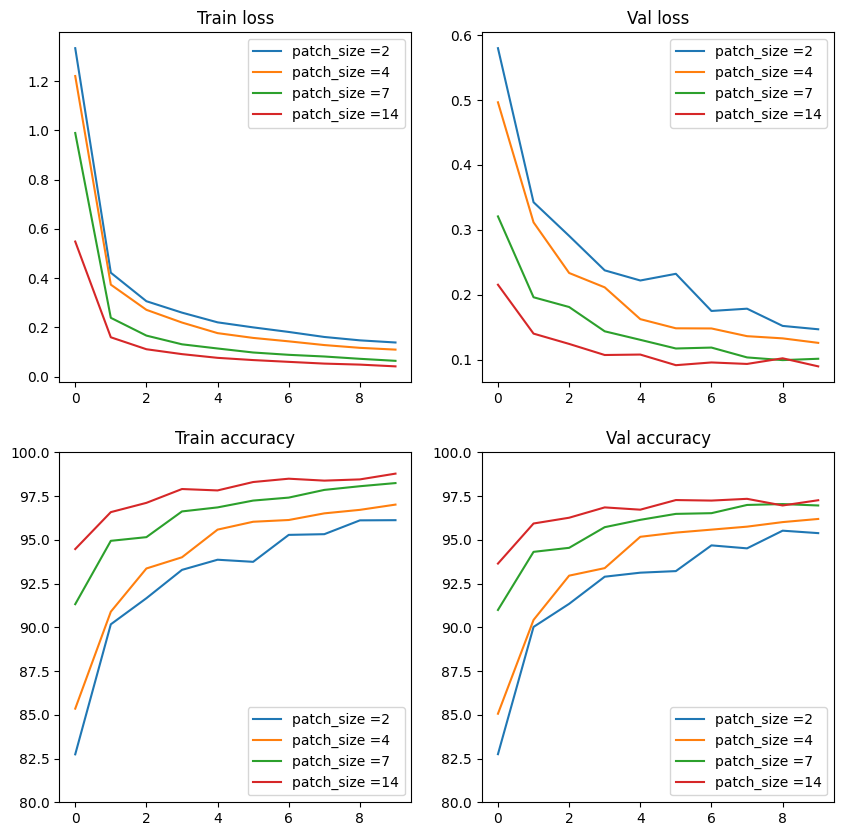

In [ ]:
fig1, axes1 = plt.subplots(2, 2, figsize=(10, 10))
axes1[0,0].set_title('Train loss')
axes1[0,1].set_title('Val loss')
axes1[1,0].set_title('Train accuracy')
axes1[1,1].set_title('Val accuracy')
for i,patch_size in enumerate([2,4,7,14]):
  axes1[0,0].plot(np.array(LOSS_train_p[i])/len(train_loader),label="patch_size ={}".format(patch_size))
  axes1[0,1].plot(np.array(LOSS_val_p[i])/len(val_loader),label="patch_size ={}".format(patch_size))
  axes1[1,0].plot(ACC_train_p[i],label="patch_size ={}".format(patch_size))
  axes1[1,1].plot(ACC_val_p[i],label="patch_size ={}".format(patch_size))

axes1[0,0].legend()
axes1[1,0].legend()
axes1[0,1].legend()
axes1[1,1].legend()
axes1[1,1].set_ylim(80,100)
axes1[1,0].set_ylim(80,100)
fig1.savefig('patch_size choices')

In [ ]:
epochs = 10

ACC_train_b=[]
ACC_val_b=[]
LOSS_train_b=[]
LOSS_val_b=[]

embed_dim = 32
patch_size = 14
nb_blocks = 2

for nb_blocks in [1,2,3,5]:

  ACC_train_temp=[]
  ACC_val_temp=[]
  LOSS_train_temp=[]
  LOSS_val_temp=[]


  model = ViT(embed_dim, nb_blocks, patch_size).cuda()

  opt = torch.optim.Adam(model.parameters())

  for epoch in range(epochs):
    train_loss = 0.
    for x, y in train_loader:
      x, y = x.cuda(), y.cuda()

      opt.zero_grad()
      yhat = model(x)
      loss = F.cross_entropy(yhat, y)
      loss.backward()

      opt.step()

      train_loss += loss.item()
  for epoch in range(epochs):
    train_loss = 0.
    val_loss=0.
    for x, y in train_loader:
      x, y = x.cuda(), y.cuda()

      opt.zero_grad()
      yhat = model(x)
      loss = F.cross_entropy(yhat, y)
      loss.backward()

      opt.step()

      train_loss += loss.item()

    for x, y in val_loader:
      x, y = x.cuda(), y.cuda()

      opt.zero_grad()
      yhat = model(x)
      loss = F.cross_entropy(yhat, y)
      loss.backward()

      opt.step()

      val_loss += loss.item()

    acc_train=eval_model(model, train_loader)
    acc_val=eval_model(model, val_loader)

    ACC_train_temp.append(acc_train)
    ACC_val_temp.append(acc_val)
    LOSS_train_temp.append(train_loss)
    LOSS_val_temp.append(val_loss)

    print(f"--- Epoch {epoch} ---")
    print(f"Train loss: {train_loss / len(train_loader)}")
  acc = eval_model(model, test_loader)
  print(f"Test accuracy: {acc}")
  ACC_train_b.append(ACC_train_temp)
  ACC_val_b.append(ACC_val_temp)
  LOSS_train_b.append(LOSS_train_temp)
  LOSS_val_b.append(LOSS_val_temp)


--- Epoch 0 ---
Train loss: 0.0565070044187208
--- Epoch 1 ---
Train loss: 0.05298818070068955
--- Epoch 2 ---
Train loss: 0.04722088879843553
--- Epoch 3 ---
Train loss: 0.0457408987643818
--- Epoch 4 ---
Train loss: 0.04220212204568088
--- Epoch 5 ---
Train loss: 0.04051688603622218
--- Epoch 6 ---
Train loss: 0.03758179409181078
--- Epoch 7 ---
Train loss: 0.03516347905496756
--- Epoch 8 ---
Train loss: 0.03139902188691
--- Epoch 9 ---
Train loss: 0.030639096717971066
Test accuracy: 97.36
--- Epoch 0 ---
Train loss: 0.03772104134162267
--- Epoch 1 ---
Train loss: 0.03255313372549911
--- Epoch 2 ---
Train loss: 0.03256358420476317
--- Epoch 3 ---
Train loss: 0.029416717942804097
--- Epoch 4 ---
Train loss: 0.025949143634798628
--- Epoch 5 ---
Train loss: 0.02625071205633382
--- Epoch 6 ---
Train loss: 0.02194954114500433
--- Epoch 7 ---
Train loss: 0.02377142863161862
--- Epoch 8 ---
Train loss: 0.019518879730254412
--- Epoch 9 ---
Train loss: 0.018770929290913046
Test accuracy: 98.0

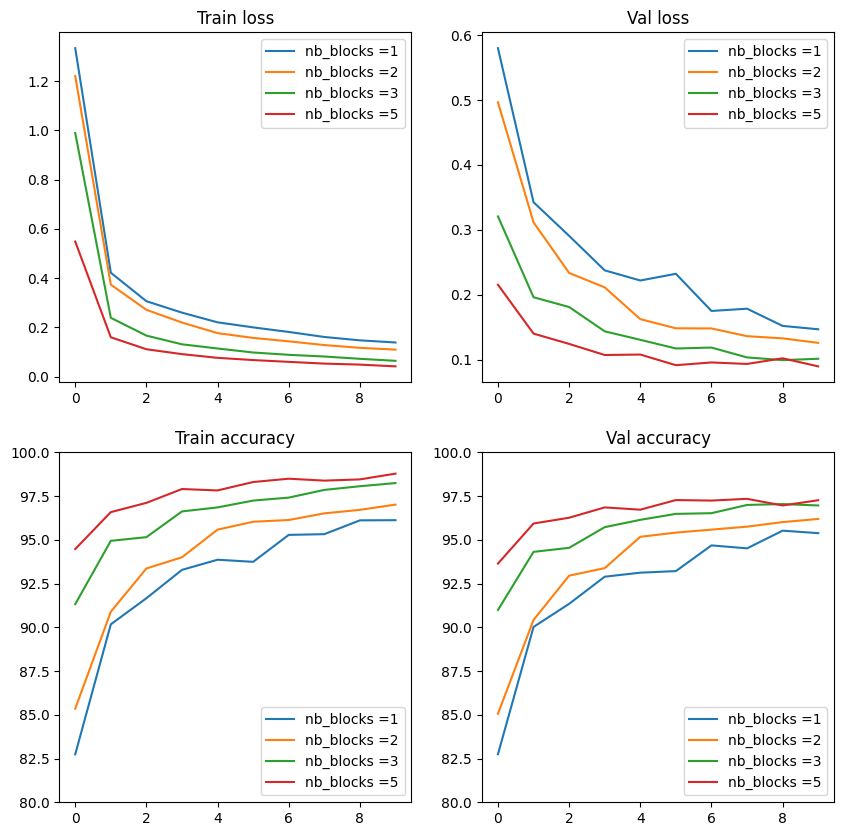

In [ ]:
fig1, axes1 = plt.subplots(2, 2, figsize=(10, 10))
axes1[0,0].set_title('Train loss')
axes1[0,1].set_title('Val loss')
axes1[1,0].set_title('Train accuracy')
axes1[1,1].set_title('Val accuracy')
for i,nb_blocks in enumerate([1,2,3,5]):
  axes1[0,0].plot(np.array(LOSS_train_p[i])/len(train_loader),label="nb_blocks ={}".format(nb_blocks))
  axes1[0,1].plot(np.array(LOSS_val_p[i])/len(val_loader),label="nb_blocks ={}".format(nb_blocks))
  axes1[1,0].plot(ACC_train_p[i],label="nb_blocks ={}".format(nb_blocks))
  axes1[1,1].plot(ACC_val_p[i],label="nb_blocks ={}".format(nb_blocks))

axes1[0,0].legend()
axes1[1,0].legend()
axes1[0,1].legend()
axes1[1,1].legend()
axes1[1,1].set_ylim(80,100)
axes1[1,0].set_ylim(80,100)
fig1.savefig('nb_blocks choices')

In [ ]:
epochs = 10

embed_dim = 128
patch_size = 14
nb_blocks = 5


ACC_train_all=[]
ACC_val_all=[]
LOSS_train_all=[]
LOSS_val_all=[]


model = ViT(embed_dim, nb_blocks, patch_size).cuda()

opt = torch.optim.Adam(model.parameters())

for epoch in range(epochs):
  train_loss = 0.
  for x, y in train_loader:
    x, y = x.cuda(), y.cuda()

    opt.zero_grad()
    yhat = model(x)
    loss = F.cross_entropy(yhat, y)
    loss.backward()

    opt.step()

    train_loss += loss.item()
  acc_train=eval_model(model, train_loader)
  acc_val=eval_model(model, val_loader)

  x_val,y_val=next(iter(val_loader))
  x_val, y_val = x_val.cuda(), y_val.cuda()
  yhat_val = model(x_val)
  loss_val = F.cross_entropy(yhat_val, y_val)
  ACC_train_all.append(acc_train)
  ACC_val_all.append(acc_val)
  LOSS_train_all.append(train_loss/ len(train_loader))
  LOSS_val_all.append(loss_val.item())

  print(f"--- Epoch {epoch} ---")
  print(f"Train loss: {train_loss / len(train_loader)}")
acc = eval_model(model, test_loader)
print(f"Test accuracy: {acc}")


--- Epoch 0 ---
Train loss: 0.3730735075076421
--- Epoch 1 ---
Train loss: 0.1193650836199522
--- Epoch 2 ---
Train loss: 0.09377790877471368
--- Epoch 3 ---
Train loss: 0.07287632761398952
--- Epoch 4 ---
Train loss: 0.06740677543605367
--- Epoch 5 ---
Train loss: 0.05918964271744092
--- Epoch 6 ---
Train loss: 0.05436754201973478
--- Epoch 7 ---
Train loss: 0.05519570836549004
--- Epoch 8 ---
Train loss: 0.050473803364361323
--- Epoch 9 ---
Train loss: 0.04727583245063822
Test accuracy: 97.93


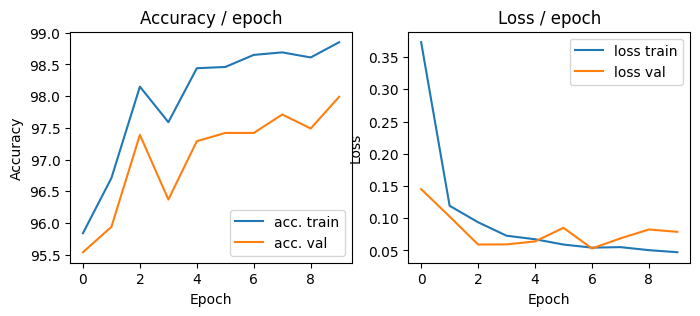

In [ ]:
plt.figure(figsize=(8,3))
plt.subplot(1,2,1)
plt.plot(np.array(ACC_train_all), label="acc. train")
plt.plot(np.array(ACC_val_all), label="acc. val")
plt.title("Accuracy / epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.subplot(1,2,2)
plt.plot(np.array(LOSS_train_all), label="loss train")
plt.plot(np.array(LOSS_val_all), label="loss val")
plt.title("Loss / epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.savefig('Optimized performance')
plt.show()

In [ ]:
X_test,Y_test=next(iter(test_loader))
X_test=X_test.cuda()
Y_test_hat=model(X_test)
Y_test_hat_copies=Y_test_hat.cpu()

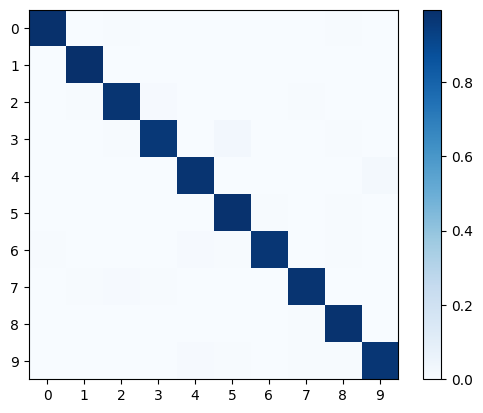

In [ ]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(Y_test, Y_test_hat_copies.argmax(dim=1))
cm=cm/cm.sum(axis=1)[:, np.newaxis]
plt.imshow(cm, cmap=plt.cm.Blues)
plt.colorbar()
plt.xticks(range(10))
plt.yticks(range(10))
plt.savefig('confusion_matrix optimized')

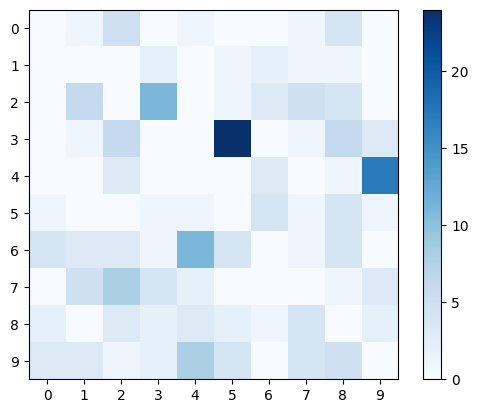

In [ ]:
cm=confusion_matrix(Y_test, Y_test_hat_copies.argmax(dim=1))
np.fill_diagonal(cm, 0)
plt.imshow(cm, cmap=plt.cm.Blues)
plt.colorbar()
plt.xticks(range(10))
plt.yticks(range(10))
plt.savefig('confusion_matrix original miclassed')

# Q8: larger transformers

Try to use bigger transformer, for example the ViT-S from the timm library. Test with and without intialization from imagenet.

a) Load the model using the timm library without pretrained wewights. Try to apply it directly on a tensor with the same MNIST images resolution. What it is the problem and why we have it? Explain if we have also such problem with CNNs. As ViT takes RGB images, the input tensor should have 3 channels.

In [6]:
!pip install timm

In [7]:
import timm
# Define the input size
input_size = 28

# Define the number of classes (output size)
num_classes = 10

# Load a model from timm (e.g., ResNet-18)
model = timm.create_model('resnet18', pretrained=False, num_classes=num_classes)

In [8]:
x = torch.randn(32, 1, 28, 28)
x = torch.cat([x] * 3, dim=1) # adapt number of channels to fit in ViT
model(x).shape

torch.Size([32, 10])

b) There is a trcik in timm that allows to use pretrained models with different image resolution and number of classes. Try to reload the model to be able to use on MNIST images:

In [9]:
input_size = 28

# Define the number of classes (output size)
num_classes = 10

# Load a model from timm (e.g., ResNet-18)
model = timm.create_model('resnet18', pretrained=False, num_classes=num_classes,in_chans=1)
model(torch.randn(32, 1, 28, 28)).shape

torch.Size([32, 10])

In [10]:
@torch.no_grad()
def eval_model(model, loader, num_channels=1):
  model.eval()
  acc = 0.
  c = 0

  for x, y in loader:
    x, y = x.cuda(), y.cuda()
    #x = torch.cat([x] * num_channels, dim=1)# adapt number of channels to fit in ViT

    yhat = model(x)

    acc += torch.sum(yhat.argmax(dim=1) == y).cpu().item()
    c += len(x)

  model.train()
  return round(100 * acc / c, 2)

In [ ]:
ACC_train_unpre=[]
ACC_val_unpre=[]
LOSS_train_unpre=[]
LOSS_val_unpre=[]

model = timm.create_model('vit_small_patch16_224', pretrained=False, num_classes=num_classes)

model.cuda()
model.train()

epochs = 10

opt = torch.optim.Adam(model.parameters())

for epoch in range(epochs):
  train_loss = 0.
  for x, y in train_loader:
    x, y = x.cuda(), y.cuda()
    x= torch.cat([x] * 3, dim=1)
    opt.zero_grad()
    yhat = model(x)
    loss = F.cross_entropy(yhat, y)
    loss.backward()

    opt.step()

    train_loss += loss.item()

  acc_train=eval_model(model, train_loader, num_channels=3)
  acc_val=eval_model(model, val_loader, num_channels=3)

  x_val,y_val=next(iter(val_loader))
  x_val, y_val = x_val.cuda(), y_val.cuda()
  x_val= torch.cat([x_val] * 3, dim=1)
  yhat_val = model(x_val)
  loss_val = F.cross_entropy(yhat_val, y_val)
  ACC_train_unpre.append(acc_train)
  ACC_val_unpre.append(acc_val)
  LOSS_train_unpre.append(train_loss/ len(train_loader))
  LOSS_val_unpre.append(loss_val.item())


  print(f"--- Epoch {epoch} ---")
  print(f"Train loss: {train_loss / len(train_loader)}")

acc = eval_model(model, test_loader, num_channels=3)
print(f"Test accuracy: {acc}")


In [ ]:
plt.figure(figsize=(8,3))
plt.subplot(1,2,1)
plt.plot(np.array(ACC_train_unpre), label="acc. train")
plt.plot(np.array(ACC_val_unpre), label="acc. val")
plt.title("Accuracy / epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.subplot(1,2,2)
plt.plot(np.array(LOSS_train_unpre), label="loss train")
plt.plot(np.array(LOSS_val_unpre), label="loss val")
plt.title("Loss / epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.savefig('Unpretrained performance')
plt.show()

In [ ]:
import timm
model = timm.create_model('vit_small_patch16_224', pretrained=False, num_classes=num_classes,in_chans=1)

model.cuda()
model.train()

epochs = 10

opt = torch.optim.Adam(model.parameters())

for epoch in range(epochs):
  train_loss = 0.
  for x, y in train_loader:
    x, y = x.cuda(), y.cuda()

    opt.zero_grad()
    yhat = model(x)
    loss = F.cross_entropy(yhat, y)
    loss.backward()

    opt.step()

    train_loss += loss.item()

  print(f"--- Epoch {epoch} ---")
  print(f"Train loss: {train_loss / len(train_loader)}")

acc = eval_model(model, test_loader, num_channels=1)
print(f"Test accuracy: {acc}")

--- Epoch 0 ---
Train loss: 0.14637692209581535
--- Epoch 1 ---
Train loss: 0.054860695311178764
--- Epoch 2 ---
Train loss: 0.038073870357126
--- Epoch 3 ---
Train loss: 0.027328028459101917
--- Epoch 4 ---
Train loss: 0.0248916976453426
--- Epoch 5 ---
Train loss: 0.01867056826657305
--- Epoch 6 ---
Train loss: 0.019020528226314733
--- Epoch 7 ---
Train loss: 0.016476607494521886
--- Epoch 8 ---
Train loss: 0.01553340668475721
--- Epoch 9 ---
Train loss: 0.011974842478016702
Test accuracy: 98.74


In [ ]:
X_test,Y_test=next(iter(test_loader))
X_test=X_test.cuda()
Y_test_hat=model(X_test)
Y_test_hat_copies=Y_test_hat.cpu()

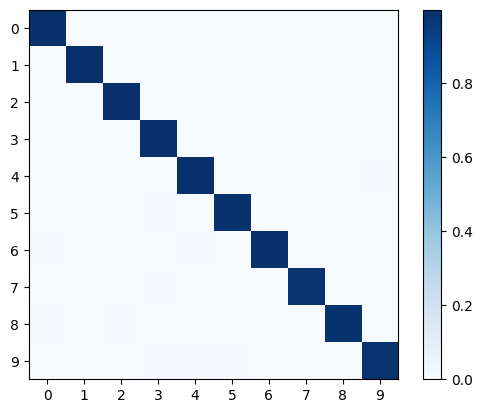

In [ ]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(Y_test, Y_test_hat_copies.argmax(dim=1))
cm=cm/cm.sum(axis=1)[:, np.newaxis]
plt.imshow(cm, cmap=plt.cm.Blues)
plt.colorbar()
plt.xticks(range(10))
plt.yticks(range(10))
plt.savefig('confusion_matrix unpretrained')

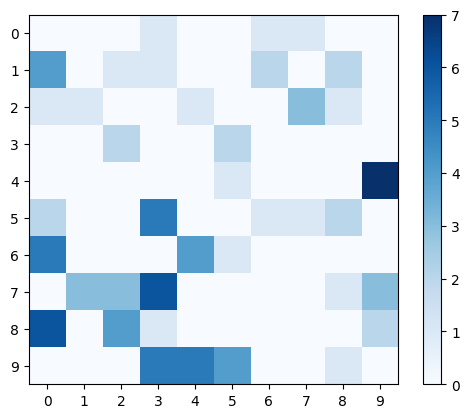

In [ ]:
cm=confusion_matrix(Y_test, Y_test_hat_copies.argmax(dim=1))
np.fill_diagonal(cm, 0)
plt.imshow(cm, cmap=plt.cm.Blues)
plt.colorbar()
plt.xticks(range(10))
plt.yticks(range(10))
plt.savefig('confusion_matrix unpretrained misclassed')

c) redo the training but with the ViT-S pretrained on ImageNet

In [ ]:
ACC_train_pre=[]
ACC_val_pre=[]
LOSS_train_pre=[]
LOSS_val_pre=[]

model = timm.create_model('vit_small_patch16_224', pretrained=True, num_classes=num_classes)

model.cuda()
model.train()

epochs = 10

opt = torch.optim.Adam(model.parameters())

for epoch in range(epochs):
  train_loss = 0.
  for x, y in train_loader:
    x, y = x.cuda(), y.cuda()
    x= torch.cat([x] * 3, dim=1)
    opt.zero_grad()
    yhat = model(x)
    loss = F.cross_entropy(yhat, y)
    loss.backward()

    opt.step()

    train_loss += loss.item()

  acc_train=eval_model(model, train_loader, num_channels=3)
  acc_val=eval_model(model, val_loader, num_channels=3)

  x_val,y_val=next(iter(val_loader))
  x_val, y_val = x_val.cuda(), y_val.cuda()
  x_val= torch.cat([x_val] * 3, dim=1)
  yhat_val = model(x_val)
  loss_val = F.cross_entropy(yhat_val, y_val)
  ACC_train_pre.append(acc_train)
  ACC_val_pre.append(acc_val)
  LOSS_train_pre.append(train_loss/ len(train_loader))
  LOSS_val_pre.append(loss_val.item())


  print(f"--- Epoch {epoch} ---")
  print(f"Train loss: {train_loss / len(train_loader)}")

acc = eval_model(model, test_loader, num_channels=3)
print(f"Test accuracy: {acc}")


--- Epoch 0 ---
Train loss: 0.21947644747296968
--- Epoch 1 ---
Train loss: 0.03866821737339099
--- Epoch 2 ---
Train loss: 0.02579096483873824
--- Epoch 3 ---
Train loss: 0.02157853581965901
--- Epoch 4 ---
Train loss: 0.0169894141528445
--- Epoch 5 ---
Train loss: 0.013369907575038573
--- Epoch 6 ---
Train loss: 0.011535652582320229
--- Epoch 7 ---
Train loss: 0.013173046912027834
--- Epoch 8 ---
Train loss: 0.012202319357485976
--- Epoch 9 ---
Train loss: 0.011276468718385634
Test accuracy: 99.33


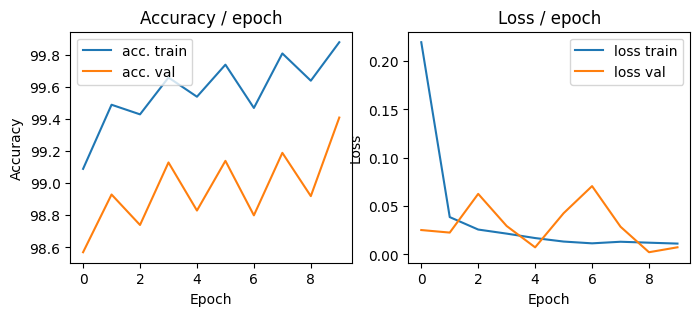

In [ ]:
plt.figure(figsize=(8,3))
plt.subplot(1,2,1)
plt.plot(np.array(ACC_train_pre), label="acc. train")
plt.plot(np.array(ACC_val_pre), label="acc. val")
plt.title("Accuracy / epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.subplot(1,2,2)
plt.plot(np.array(LOSS_train_pre), label="loss train")
plt.plot(np.array(LOSS_val_pre), label="loss val")
plt.title("Loss / epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.savefig('Pretrained performance')
plt.show()

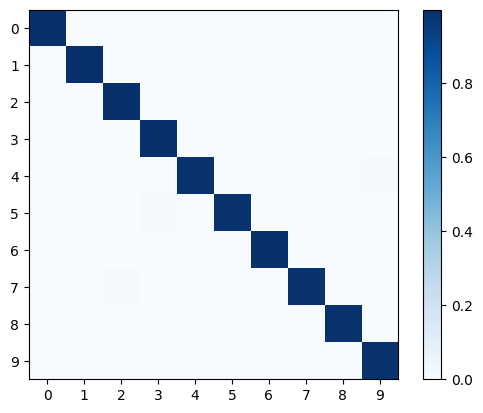

In [ ]:
X_test,Y_test=next(iter(test_loader))
X_test=X_test.cuda()
X_test= torch.cat([X_test] * 3, dim=1)
Y_test_hat=model(X_test)
Y_test_hat_copies=Y_test_hat.cpu()
cm=confusion_matrix(Y_test, Y_test_hat_copies.argmax(dim=1))
cm=cm/cm.sum(axis=1)[:, np.newaxis]
plt.imshow(cm, cmap=plt.cm.Blues)
plt.colorbar()
plt.xticks(range(10))
plt.yticks(range(10))
plt.savefig('confusion_matrix pretrained')

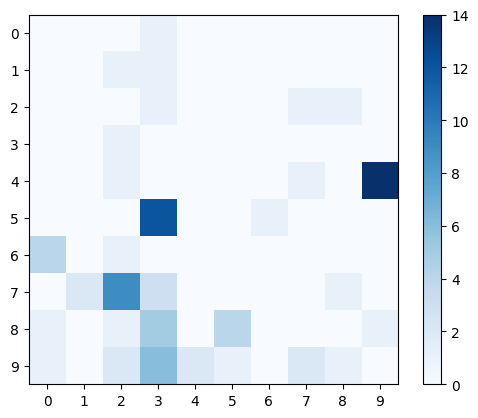

In [ ]:
cm=confusion_matrix(Y_test, Y_test_hat_copies.argmax(dim=1))
np.fill_diagonal(cm, 0)
plt.imshow(cm, cmap=plt.cm.Blues)
plt.colorbar()
plt.xticks(range(10))
plt.yticks(range(10))
plt.savefig('confusion_matrix pretrained misclassed')

c) image net

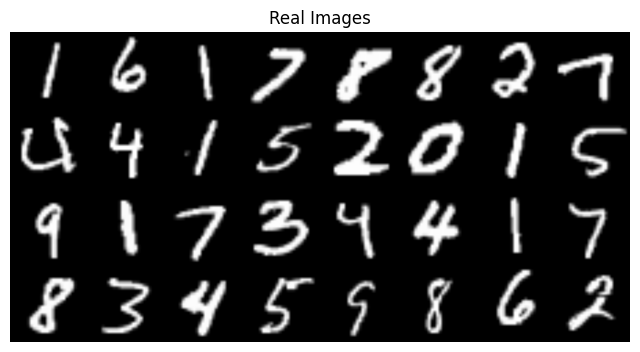

In [12]:

# Define the transformation
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # Convert to RGB
    transforms.Resize((224, 224)),  # Resize to match ViT input size
    transforms.ToTensor(),
])

batch_size=32

# Load the full MNIST dataset
full_dataset = torchvision.datasets.MNIST('.', train=True, download=True, transform=transform)

# Define the sizes of the training and validation sets
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size

# Split the dataset into training and validation sets
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# Create data loaders for training, validation, and testing
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_dataset = torchvision.datasets.MNIST('.', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset))

real_batch = next(iter(train_loader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Real Images")
plt.imshow(vutils.make_grid(real_batch[0][:64], normalize=True).permute(1,2,0))
plt.show()

In [13]:
real_batch[0].shape

torch.Size([32, 3, 224, 224])

In [14]:
import torch
import torchvision
import torchvision.transforms as transforms
import timm
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
# Define the model name
model_name = 'vit_small_patch16_224'

class CustomViT(nn.Module):
    def __init__(self, model_name, num_classes):
        super(CustomViT, self).__init__()
        self.vit = timm.create_model(model_name, pretrained=True)
        # Modify the input layer to accept 1 channel
        #self.vit.patch_embed.proj = nn.Conv2d(1, self.vit.patch_embed.num_patches, kernel_size=16, stride=16)
        self.fc = nn.Linear(1000, num_classes)

    def forward(self, x):
        x = self.vit(x)
        x = self.fc(x)
        return x

model = CustomViT(model_name, num_classes=10)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [15]:
model.cuda()
model.train()
model(real_batch[0].cuda())

tensor([[-1.2091e+00, -9.3246e-01, -3.5110e-01, -4.2492e-02,  7.2648e-01,
         -3.1511e-01, -1.0875e+00, -9.5889e-01,  7.3510e-01,  9.3404e-02],
        [-4.4942e-01, -9.5227e-01, -4.9208e-01,  6.1382e-01,  1.3687e+00,
         -2.1021e-01, -4.1090e-01, -7.8583e-01,  1.6301e+00, -9.2646e-01],
        [-7.2594e-01, -6.7597e-01,  4.6514e-02,  3.2748e-02,  8.0394e-01,
         -1.2539e-01, -1.2066e+00, -1.0283e+00,  8.9855e-01,  3.0512e-04],
        [-1.7530e-01, -8.7272e-01, -3.6483e-01,  7.4273e-02,  9.5284e-01,
         -5.8471e-02, -1.0945e+00, -1.4505e+00,  1.4866e+00, -3.1796e-01],
        [-2.1016e-01, -1.3097e-01, -1.0853e-01, -4.2488e-01,  1.1855e+00,
         -1.2727e-01, -4.7820e-01, -1.0793e+00,  1.3193e+00, -4.0211e-01],
        [-4.0138e-01, -5.4148e-01, -8.5447e-01,  7.0798e-01,  1.5210e+00,
         -4.4398e-01, -5.2361e-01, -2.5615e-01,  1.7329e+00, -6.0563e-01],
        [-3.3806e-01, -6.3914e-01, -1.0244e-02, -7.5876e-03,  1.6998e+00,
          5.1664e-01, -3.7745e-0

In [22]:
ACC_train_pre=[]
ACC_val_pre=[]
LOSS_train_pre=[]
LOSS_val_pre=[]

epochs = 5
model.cuda()
model.train()
opt = torch.optim.Adam(model.parameters(), lr = 0.0001)


for epoch in range(epochs):
  train_loss = 0.
  for x, y in train_loader:
    x, y = x.cuda(), y.cuda()
    opt.zero_grad()
    yhat = model(x)
    loss = F.cross_entropy(yhat, y)
    loss.backward()

    opt.step()

    train_loss += loss.item()
  # train_loss=loss.item()
  acc_train=eval_model(model, train_loader)
  acc_val=eval_model(model, val_loader)

  val_loss = 0.
  for x_val, y_val in val_loader:
    x_val, y_val = x_val.cuda(), y_val.cuda()
    yhat_val = model(x_val)
    loss_val = F.cross_entropy(yhat_val, y_val)
    val_loss += loss_val.item()

  ACC_train_pre.append(acc_train)
  ACC_val_pre.append(acc_val)
  LOSS_train_pre.append(train_loss/ len(train_loader))
  LOSS_val_pre.append(val_loss/len(val_loader))


  print(f"--- Epoch {epoch} ---")
  print(f"Train loss: {train_loss / len(train_loader)}")

# acc = eval_model(model, test_loader)
# print(f"Test accuracy: {acc}")


--- Epoch 0 ---
Train loss: 0.028720411722316083
--- Epoch 1 ---
Train loss: 0.021408597997595886
--- Epoch 2 ---
Train loss: 0.020632806240346933
--- Epoch 3 ---
Train loss: 0.016961782822110156
--- Epoch 4 ---
Train loss: 0.0171217343738305


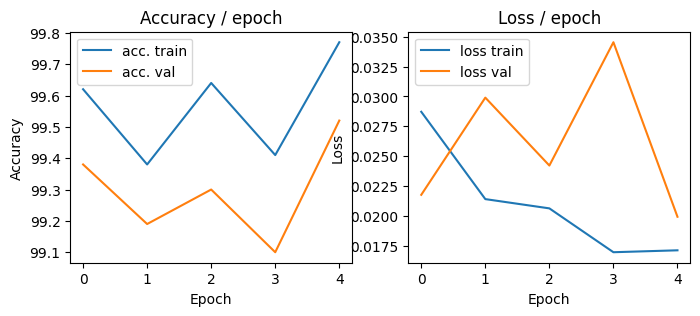

In [23]:
plt.figure(figsize=(8,3))
plt.subplot(1,2,1)
plt.plot(np.array(ACC_train_pre), label="acc. train")
plt.plot(np.array(ACC_val_pre), label="acc. val")
plt.title("Accuracy / epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.subplot(1,2,2)
plt.plot(np.array(LOSS_train_pre), label="loss train")
plt.plot(np.array(LOSS_val_pre), label="loss val")
plt.title("Loss / epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.savefig('Pretrained Imagenet performance')
plt.show()

In [ ]:
X_test,Y_test=next(iter(test_loader))
X_test=X_test.cuda()
X_test= torch.cat([X_test] * 3, dim=1)
Y_test_hat=model(X_test)
Y_test_hat_copies=Y_test_hat.cpu()
cm=confusion_matrix(Y_test, Y_test_hat_copies.argmax(dim=1))
cm=cm/cm.sum(axis=1)[:, np.newaxis]
plt.imshow(cm, cmap=plt.cm.Blues)
plt.colorbar()
plt.xticks(range(10))
plt.yticks(range(10))
plt.savefig('confusion_matrix pretrained inagenet')

In [ ]:
cm=confusion_matrix(Y_test, Y_test_hat_copies.argmax(dim=1))
np.fill_diagonal(cm, 0)
plt.imshow(cm, cmap=plt.cm.Blues)
plt.colorbar()
plt.xticks(range(10))
plt.yticks(range(10))
plt.savefig('confusion_matrix pretrained imagenet misclassed')

d) Comment the final results and provide some ideas on how to make transformer work on small datasets. You can take inspiration from some recent work.